In [13]:
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn as sk
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import package to count number of hours after specific time
from datetime import datetime


In [16]:
file_path = 'Data/AQ_CS_All_Full.csv'


# Faerier, adjusts for modulation, 7, 31
# Plot residuals to Faerier plot

# Define file paths
#combined_dataset = "/home/henry-cao/Desktop/KCL/Extracurriculars/CUSP/Project_Code/Datasets/no_na_dataset.csv"

# Load data
data = pd.read_csv(file_path)


# Print col names
print(data.columns)

# Print number of rows
print("Number of rows before preprocessing: ", data.shape[0])

# Only keep unique rows
data = data.drop_duplicates()

# Drop na values from Measurement, SatMean, and FlowMean
data = data.dropna(subset=['Measurement', 'SatMean', 'FlowMean'])

# When SatMean is less than 0, set value to na
data.loc[data['SatMean'] < 0, 'SatMean'] = np.nan

# Covert time column to datetime
data['time_temp'] = pd.to_datetime(data['MeasurementDateGMT'])

# Find earliest timestamp
earliest_timestamp = data['time_temp'].min()

# Calculated time elapsed
data['time_elapsed'] = data['time_temp'] - earliest_timestamp

# Turn time_elapsed into float32
data['time_elapsed'] = data['time_elapsed'].dt.total_seconds().astype('float32')

# Drop MeasurementDateGMT and time columns
data = data.drop(columns=['time_temp'])

# Convert certain categorical variables to numerical encoded values
data['SiteType'] = data['SiteType'].astype('category').cat.codes

# Store unique values of SpeciesType
unique_species_values = data['SpeciesType'].unique()

# Convert SpeciesType to numerical encoded values, and link up unique_species_values w/ numerical values
data['SpeciesType'] = data['SpeciesType'].astype('category').cat.codes
unique_species_dict = {i: unique_species_values[i] for i in range(len(unique_species_values))}

# Turn time, which represents exact hour of the day, into numerical
data['Hour'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').hour).astype(int)

# Extract day, month, and year from MeasurmentDateGMT
# Day is in index 0-1, month is in index 5-7, year is in index 9-12
# Time is in format YYYY-MM-DD HH:MM
data['Day'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').day).astype(int)
data['Month'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').month).astype(int)
data['Year'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').year).astype(int)

# Dropping irrelevant or redundant columns
data = data.drop(columns=['MeasurementDateGMT', 'LocalAuthorityName', 'SiteCode', 'LocalAuthorityCode', 'SiteName', 'DateOpened', 'DateClosed', 'ID', 'DateTime', 'date',  'Date', 'SatBand', 'DateTimeStr', 'Time'])

# Print number of rows
print("Number of rows after preprocessing: ", data.shape[0])

# Define input size annd output size based on data shape
num_features = data.shape[1] - 1

# Making sure dropped columns are gone
print(f"Columns remaining: {data.columns}")


Index(['MeasurementDateGMT', 'Measurement', 'SiteCode', 'LocalAuthorityCode',
       'LocalAuthorityName', 'SiteName', 'SiteType', 'DateOpened',
       'DateClosed', 'Latitude', 'Longitude', 'SpeciesType', 'ID', 'DateTime',
       'Date', 'Time', 'SatMean', 'SatBand', 'FlowMean', 'DateTimeStr', 'date',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'wind_speed_10m (km/h)', 'wind_direction_10m (°)'],
      dtype='object')
Number of rows before preprocessing:  389033
Number of rows after preprocessing:  389011
Columns remaining: Index(['Measurement', 'SiteType', 'Latitude', 'Longitude', 'SpeciesType',
       'SatMean', 'FlowMean', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'wind_speed_10m (km/h)',
       'wind_direction_10m (°)', 'time_elapsed', 'Hour', 'Day', 'Month',
       'Year'],
      dtype='object')


In [17]:
import tensorflow as tf

# 检查GPU设备
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPU")
    except RuntimeError as e:
        # 
        print(e)
else:
    print("No GPU found, using CPU instead.")

No GPU found, using CPU instead.


In [18]:

# Make test and training sets, with Measurements as response variable and
# all other variables as predictors
X = data.drop(columns=['Measurement'])
y = data['Measurement']

# Converting datatypes to float32
X = X.astype('float32')
y = y.astype('float32')

# # Initialise MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled = scaler.fit_transform(X)


In [23]:
unique_species_dict

{0: 'NO2', 1: 'PM10', 2: 'PM25', 3: 'SO2'}

Pollutant: NO2
Epoch 1/200
449/449 [==============================] - 21s 38ms/step - loss: 728.1846 - val_loss: 437.3213
Epoch 2/200
449/449 [==============================] - 16s 36ms/step - loss: 451.6725 - val_loss: 564.3235
Epoch 3/200
449/449 [==============================] - 16s 35ms/step - loss: 384.0079 - val_loss: 578.6982
Epoch 4/200
449/449 [==============================] - 16s 36ms/step - loss: 330.0118 - val_loss: 580.1012
Epoch 5/200
449/449 [==============================] - 16s 35ms/step - loss: 299.9376 - val_loss: 573.1774
Epoch 6/200
449/449 [==============================] - 17s 37ms/step - loss: 276.5659 - val_loss: 742.8091
Epoch 7/200
449/449 [==============================] - 16s 35ms/step - loss: 260.7785 - val_loss: 690.5209
Epoch 8/200
449/449 [==============================] - 15s 33ms/step - loss: 246.9020 - val_loss: 964.2652
Epoch 9/200
449/449 [==============================] - 15s 33ms/step - loss: 236.1526 - val_loss: 943.8314
Epoch 10/200
449/449 [

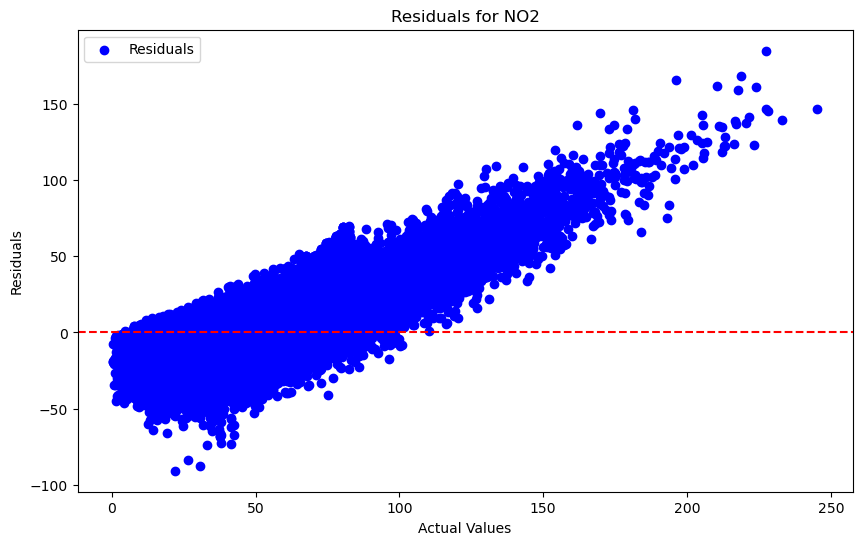

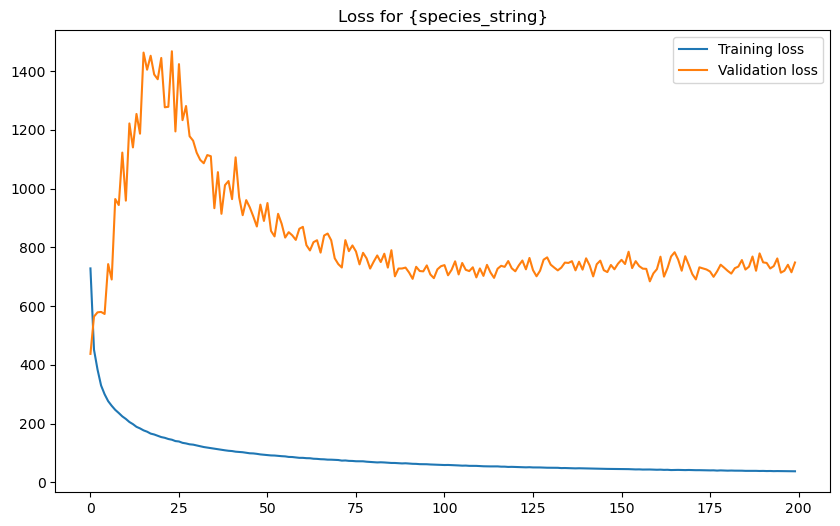

Mean squared error for {species}:  586.7456
Pollutant: PM10
Epoch 1/200
357/357 [==============================] - 33s 80ms/step - loss: 185.0261 - val_loss: 111.3658
Epoch 2/200
357/357 [==============================] - 14s 38ms/step - loss: 135.8203 - val_loss: 106.8712
Epoch 3/200
357/357 [==============================] - 14s 40ms/step - loss: 121.3891 - val_loss: 107.4156
Epoch 4/200
357/357 [==============================] - 26s 72ms/step - loss: 113.4677 - val_loss: 98.3101
Epoch 5/200
357/357 [==============================] - 14s 39ms/step - loss: 107.2289 - val_loss: 94.7417
Epoch 6/200
357/357 [==============================] - 15s 42ms/step - loss: 103.2533 - val_loss: 93.9493
Epoch 7/200
357/357 [==============================] - 14s 38ms/step - loss: 100.0584 - val_loss: 95.3321
Epoch 8/200
357/357 [==============================] - 15s 41ms/step - loss: 97.3191 - val_loss: 93.5278
Epoch 9/200
357/357 [==============================] - 14s 38ms/step - loss: 95.2841 - val

KeyboardInterrupt: 

In [21]:

# Separate by SpeciesType
unique_species = data['SpeciesType'].unique()
for species in unique_species:
    # Use unique_species_dict to print species
    species_string = unique_species_dict[species]
    print(f"Pollutant: {species_string}")

    # Filter data by species
    data_species = data[data['SpeciesType'] == species]

    # Make test and training sets, with Measurements as response variable
    X_species = data_species.drop(columns=['Measurement', 'SpeciesType'])
    y_species = data_species['Measurement']
    X_species = X_species.astype('float32')
    y_species = y_species.astype('float32')

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_species)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_species, test_size=0.2, random_state=1, shuffle=False)

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # model = Sequential([
    #     LSTM(units=500, activation='relu', input_shape=(1, X_train.shape[2]), recurrent_initializer='glorot_uniform'),
    #     Dense(1)
    # ])

    model = Sequential([
        Bidirectional(LSTM(units=500, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences = True)),
        Dropout(0.2),
        Bidirectional(LSTM(units=250, activation='relu')),
        Dropout(0.2),
        Dense(100, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    checkpoint_filepath = f"/Users/SBH/OneDrive - University College London/#CUSPLondonDataDive2024/2024CUSPLondonDataDive/ModelResults/Check/checkpoint_model_{species_string}.h5"
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    # Fit model
    history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split = 0.2, callbacks=[model_checkpoint_callback])

    # Load best model
    best_model = load_model(checkpoint_filepath)

    best_model.summary()

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Plot Residuals between real and predicted values
    y_residuals = y_test - y_pred.flatten()
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, y_residuals, color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals for {species_string}')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss for {species_string}')
    plt.legend()
    plt.show()

    # # Calculate and print accuracy of predictions
    MSE = sk.metrics.mean_squared_error(y_test, y_pred)
    print("Mean squared error for {species}: ", MSE)

Pollutant: NO2
Epoch 1/200
449/449 [==============================] - 29s 57ms/step - loss: 740.4556 - val_loss: 461.4136
Epoch 2/200
449/449 [==============================] - 29s 64ms/step - loss: 457.4808 - val_loss: 488.7201
Epoch 3/200
449/449 [==============================] - 22s 49ms/step - loss: 392.8501 - val_loss: 502.1138
Epoch 4/200
449/449 [==============================] - 21s 46ms/step - loss: 349.3652 - val_loss: 540.0129
Epoch 5/200
449/449 [==============================] - 19s 41ms/step - loss: 315.4739 - val_loss: 578.0496
Epoch 6/200
449/449 [==============================] - 19s 41ms/step - loss: 289.3177 - val_loss: 760.7522
Epoch 7/200
449/449 [==============================] - 19s 42ms/step - loss: 270.4008 - val_loss: 740.5327
Epoch 8/200
449/449 [==============================] - 19s 42ms/step - loss: 255.1487 - val_loss: 819.4508
Epoch 9/200
449/449 [==============================] - 18s 41ms/step - loss: 240.4296 - val_loss: 1028.5710
Epoch 10/200
449/449 

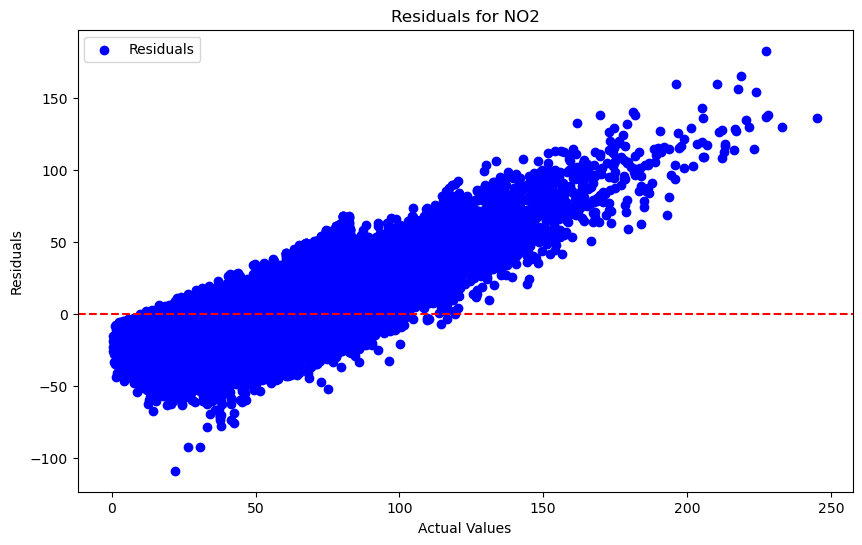

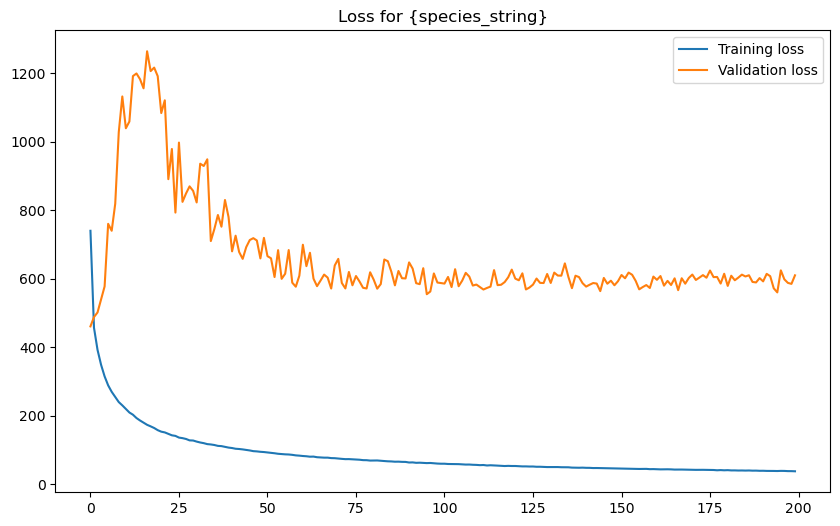

Mean squared error for {species}:  566.4352


In [26]:
species = 0
species_string = 'NO2'
print(f"Pollutant: {species_string}")

# Filter data by species
data_species = data[data['SpeciesType'] == species]

# Make test and training sets, with Measurements as response variable
X_species = data_species.drop(columns=['Measurement', 'SpeciesType'])
y_species = data_species['Measurement']
X_species = X_species.astype('float32')
y_species = y_species.astype('float32')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_species)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_species, test_size=0.2, random_state=1, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))



model = Sequential([
    Bidirectional(LSTM(units=500, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences = True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=250, activation='relu')),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

checkpoint_filepath = f"/Users/SBH/OneDrive - University College London/#CUSPLondonDataDive2024/2024CUSPLondonDataDive/ModelResults/Check/checkpoint_model_NO2.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Fit model
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split = 0.2, callbacks=[model_checkpoint_callback])

# Load best model
best_model = load_model(checkpoint_filepath)

best_model.summary()

# Make predictions
y_pred = best_model.predict(X_test)

# Plot Residuals between real and predicted values
y_residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title(f'Residuals for {species_string}')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss for {species_string}')
plt.legend()
plt.show()

# # Calculate and print accuracy of predictions
MSE = sk.metrics.mean_squared_error(y_test, y_pred)
print("Mean squared error for {species}: ", MSE)

Pollutant: SO2
Epoch 1/200
44/44 [==============================] - 7s 67ms/step - loss: 14.9908 - val_loss: 9.0703
Epoch 2/200
44/44 [==============================] - 2s 51ms/step - loss: 6.4244 - val_loss: 9.7347
Epoch 3/200
44/44 [==============================] - 2s 51ms/step - loss: 5.5663 - val_loss: 12.7608
Epoch 4/200
44/44 [==============================] - 2s 47ms/step - loss: 4.8946 - val_loss: 15.2039
Epoch 5/200
44/44 [==============================] - 2s 47ms/step - loss: 4.2889 - val_loss: 22.1400
Epoch 6/200
44/44 [==============================] - 2s 47ms/step - loss: 3.6592 - val_loss: 25.1562
Epoch 7/200
44/44 [==============================] - 2s 47ms/step - loss: 3.1618 - val_loss: 29.5671
Epoch 8/200
44/44 [==============================] - 2s 46ms/step - loss: 2.8306 - val_loss: 32.6307
Epoch 9/200
44/44 [==============================] - 2s 46ms/step - loss: 2.6247 - val_loss: 34.7494
Epoch 10/200
44/44 [==============================] - 2s 47ms/step - loss: 2.

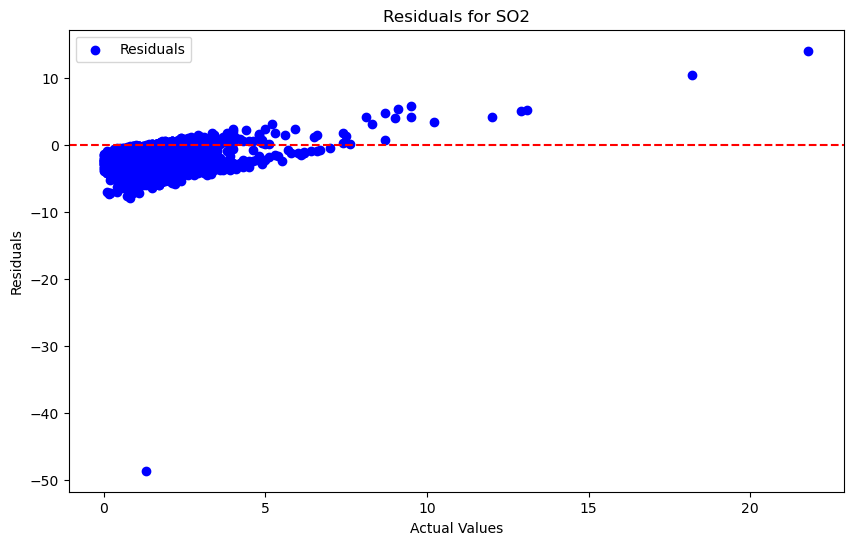

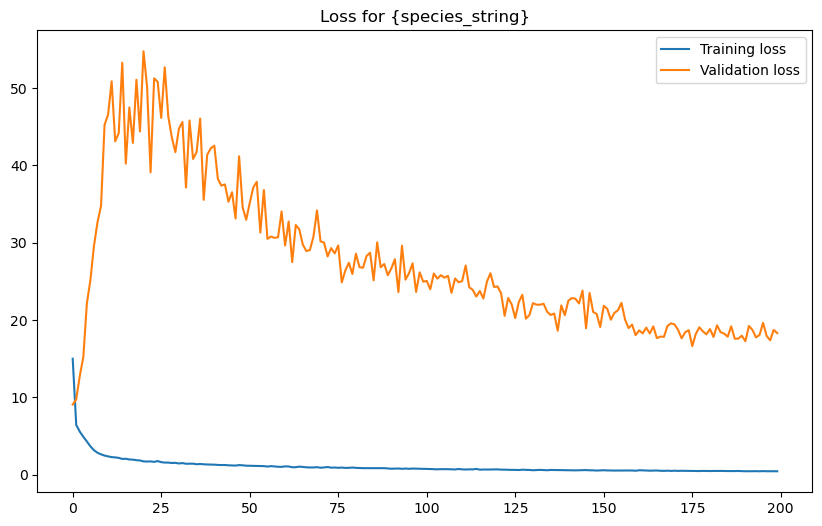

Mean squared error for {species}:  6.4390097


In [25]:
species = 3
species_string = 'SO2'
print(f"Pollutant: {species_string}")

# Filter data by species
data_species = data[data['SpeciesType'] == species]

# Make test and training sets, with Measurements as response variable
X_species = data_species.drop(columns=['Measurement', 'SpeciesType'])
y_species = data_species['Measurement']
X_species = X_species.astype('float32')
y_species = y_species.astype('float32')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_species)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_species, test_size=0.2, random_state=1, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))



model = Sequential([
    Bidirectional(LSTM(units=500, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences = True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=250, activation='relu')),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

checkpoint_filepath = f"/Users/SBH/OneDrive - University College London/#CUSPLondonDataDive2024/2024CUSPLondonDataDive/ModelResults/Check/checkpoint_model_SO2.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Fit model
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split = 0.2, callbacks=[model_checkpoint_callback])

# Load best model
best_model = load_model(checkpoint_filepath)

best_model.summary()

# Make predictions
y_pred = best_model.predict(X_test)

# Plot Residuals between real and predicted values
y_residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title(f'Residuals for {species_string}')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss for {species_string}')
plt.legend()
plt.show()

# # Calculate and print accuracy of predictions
MSE = sk.metrics.mean_squared_error(y_test, y_pred)
print("Mean squared error for {species}: ", MSE)